# Clinical Sample Validation

This notebook implements the validation pipeline from `validation_plan.md`.

**Goal:** Validate 12,100 potential clinical samples to identify real patient data with treatment response labels.

**Steps:**
1. Data Loading & Deduplication
2. Define Column Indicator Mappings
3. Column Content Analysis & Scoring
4. Group by Experiment ID & Join Metadata
5. Map Response Columns
6. Generate Prioritized Summary Report
7. Export Results

## Cell 1: Imports and Setup

In [1]:
import polars as pl
import pandas as pd
import re
from pathlib import Path
from tqdm import tqdm

# Paths
data_dir = Path('../data')

print("Imports complete")

Imports complete


## 2: Load Data & Deduplicate

Load all required data files:
- `potential_clin_data.csv`: 12,100 candidate samples
- `clin_obs.csv`: 12,380 existing clinical samples
- `response_column_shortlist_from_full_lazy.parquet`: Response columns detected
- `experiment_data.csv`: Experiment metadata

In [2]:
# Load data
print("Loading potential_clin_data.csv...")
potential_clin = pl.read_csv(
    data_dir / 'potential_clin_data.csv',
    ignore_errors=False,
    infer_schema_length=14000
)
print(f"  Shape: {potential_clin.shape}")

print("\nLoading clin_obs.csv...")
clin_obs = pd.read_csv(data_dir / 'clin_obs.csv')
print(f"  Shape: {clin_obs.shape}")

print("\nLoading response_column_shortlist_lazy.parquet...")
response_shortlist = pl.read_parquet(data_dir / 'response_column_shortlist_lazy.parquet')
print(f"  Shape: {response_shortlist.shape}")

print("\nLoading experiment_data.csv...")
experiment_data = pd.read_csv(data_dir / 'experiment_data.csv')
print(f"  Shape: {experiment_data.shape}")

print("\nAll data loaded successfully")

Loading potential_clin_data.csv...
  Shape: (12100, 1063)

Loading clin_obs.csv...
  Shape: (12380, 13)

Loading response_column_shortlist_lazy.parquet...
  Shape: (154, 8)

Loading experiment_data.csv...
  Shape: (185, 8)

All data loaded successfully


 Deduplicate Against clin_obs

Filter out samples that already exist in the clinical database.

In [3]:
# Get existing sample IDs
existing_ids = set(clin_obs['sample_id'].values)
print(f"Existing clinical samples: {len(existing_ids):,}")

# Filter out duplicates
novel_samples = potential_clin.filter(
    ~pl.col('refinebio_accession_code').is_in(existing_ids)
)

print(f"\n=== DEDUPLICATION RESULTS ===")
print(f"Original samples: {len(potential_clin):,}")
print(f"Existing clinical samples: {len(existing_ids):,}")
print(f"Novel samples to validate: {len(novel_samples):,}")
print(f"Duplicate samples removed: {len(potential_clin) - len(novel_samples):,}")
print(f"\nDeduplication complete")

Existing clinical samples: 11,735

=== DEDUPLICATION RESULTS ===
Original samples: 12,100
Existing clinical samples: 11,735
Novel samples to validate: 9,201
Duplicate samples removed: 2,899

Deduplication complete


# collumn scoring prep

##  collumn name matching

Define regex patterns to identify cell line indicators (negative signals for primary samples).

In [4]:
# Cell line column name patterns
CELL_LINE_COLUMN_PATTERNS = [
    r'.*cell[_\s]line.*',
    r'.*celltype.*',
    r'.*cell\s+type.*',
]

# Compile regex
cell_line_col_regex = re.compile('|'.join(CELL_LINE_COLUMN_PATTERNS), re.IGNORECASE)

# Known cell line names (expanded list)
CELL_LINE_NAMES = {
    'MCF7', 'MCF-7', 'HELA', 'HeLa', 'K562', 'A549', 'HEK293', 'HEK-293',
    'JURKAT', 'U937', 'THP1', 'THP-1', 'CACO2', 'Caco-2', 'HCT116',
    'SW480', 'DLD1', 'DLD-1', 'RKO', 'MDA-MB-231', 'T47D', 'BT474',
    'SKBR3', 'ZR-75-1', 'PC3', 'LNCaP', 'DU145', 'H1299', 'H460',
    'NCI-H', 'HUVEC', 'NIH3T3', 'COS7', 'CHO', 'BHK', 'MDCK',
    'U2OS', 'SAOS2', 'HT29', 'LS174T', 'SW620', 'COLO205',
    'PANC1', 'MIAPACA', 'BxPC3', 'CFPAC1', 'CAPAN1',
    'OV90', 'SKOV3', 'OVCAR', 'A2780', 'IGROV1',
    'H1975', 'H2228', 'H3122', 'A431', 'CALU',
}



 Define Primary Sample Indicator Patterns

Define regex patterns to identify primary sample indicators (positive signals for patient data).

In [5]:
# Primary sample column name patterns
# EXPANDED with lymph, metastasis, histology - USER REQUESTED
PRIMARY_SAMPLE_PATTERNS = {
    'age': r'.*\bage\b.*',
    'sex': r'.*\b(sex|gender)\b.*',
    'patient': r'.*\bpatient\b.*',
    'stage': r'.*\b(stage|grade)\b.*',
    'tissue': r'.*\b(tissue|biopsy|)\b.*',
    'lymph': r'.*\blymph\b.*',  # NEW - lymph nodes
    'metastasis': r'.*\bmetasta.*',  # NEW - metastasis/metastatic
    'histology': r'.*\bhistolog.*',  # NEW - histology/histological
}

# Compile each pattern
primary_sample_regex = {
    key: re.compile(pattern, re.IGNORECASE)
    for key, pattern in PRIMARY_SAMPLE_PATTERNS.items()
}

print(f"Primary sample indicator types: {len(PRIMARY_SAMPLE_PATTERNS)}")
for indicator_type in PRIMARY_SAMPLE_PATTERNS.keys():
    print(f"  - {indicator_type}")


Primary sample indicator types: 8
  - age
  - sex
  - patient
  - stage
  - tissue
  - lymph
  - metastasis
  - histology


## text based scoring

match free text which may inidicate cell line or primary

In [6]:
# Step 2: Define text search columns
# NOTE: Series columns can contain BOTH cell line AND primary human indicators
# They provide experiment-level context that applies to all samples in that experiment
TEXT_SEARCH_COLUMNS = [
    # Series metadata - Experiment-level context (can be EITHER cell line OR primary human)
    'series_title',
    'series_summary',
    'series_overall_design',
    
    # refinebio columns - EXPANDED with more refinebio columns
    'refinebio_title',
    'refinebio_description', 
    'refinebio_source_name',
    'refinebio_subject',
    'refinebio_age',
    'refinebio_cell_line',
    'refinebio_disease',
    'refinebio_disease_stage',
    'refinebio_sex',
    'refinebio_source_database',
    'refinebio_specimen_part',
    'refinebio_treatment',
    # GEO protocol columns (strong cell line indicators)
    'description',
    'extraction_protocol_ch1',
    'growth_protocol_ch1',
    'treatment_protocol_ch1',
]

# Filter to columns that exist in our data
text_search_cols = [col for col in TEXT_SEARCH_COLUMNS if col in novel_samples.columns]

print(f"Text search columns: {len(text_search_cols)}")
for col in text_search_cols:
    print(f"  - {col}")
print()

# Step 3: Define cell line indicator terms
# Based on examination + user guidance
CELL_LINE_TEXT_TERMS = [
    # Culture/growth terms
    r'\bcell\s+line\b',
    r'\bplated\b',
    r'\bpassage\b',
    r'\bpassaged\b',
    r'\bconfluence\b',
    r'\bconfluent\b',
    r'\bsubcultured?\b',
    r'\bcultured\s+in\b',
    r'\bgrown\s+in\b',
    r'\bmaintained\s+in\b',
    
    # Media/serum terms (very specific to cell culture)
    r'\bFBS\b',  # Fetal Bovine Serum
    r'\bfetal\s+bovine\s+serum\b',
    r'\bDMEM\b',
    r'\bRPMI\b',
    r'\bIMDM\b',
    r'\bserum[- ]free\b',
    r'\b\d+%\s+(FBS|serum)\b',  # e.g., "10% FBS"
    
    # Cell line sources
    r'\bATCC\b',  # American Type Culture Collection
    r'\btype\s+culture\s+collection\b',
    r'\bauthenticated\b',  # cell lines are authenticated
    r'\bshort\s+tandem\s+repeat\b',  # STR profiling for cell lines
    
    # Cell line manipulation
    r'\btransfected\b',
    r'\btransfection\b',
    r'\bstably\s+expressing\b',
    r'\bdoxycycline[- ]inducible\b',
    r'\binducible\s+shRNA\b',
    r'\bmycoplasma[- ]free\b',
]

# Compile into single regex
cell_line_text_regex = re.compile('|'.join(CELL_LINE_TEXT_TERMS), re.IGNORECASE)

print(f"Cell line text indicators: {len(CELL_LINE_TEXT_TERMS)} patterns")
print(f"  Examples: cell line, plated, passage, confluence, FBS, ATCC, transfected")
print()

Text search columns: 13
  - refinebio_title
  - refinebio_subject
  - refinebio_age
  - refinebio_cell_line
  - refinebio_disease
  - refinebio_disease_stage
  - refinebio_sex
  - refinebio_source_database
  - refinebio_specimen_part
  - refinebio_treatment
  - description
  - growth_protocol_ch1
  - treatment_protocol_ch1

Cell line text indicators: 27 patterns
  Examples: cell line, plated, passage, confluence, FBS, ATCC, transfected



In [7]:
# Define primary human sample indicator terms
PRIMARY_HUMAN_TEXT_TERMS = [
    # Patient/clinical terms
    r'\bpatient\b', r'\bdonor\b', r'\bindividual\b', r'\bparticipant\b',
    # Tissue/sample source terms
    r'\bbiopsy\b', r'\bbiopsies\b', r'\bresection\b', r'\bresected\b',
    r'\bsurgical\s+specimen\b', r'\btumor\s+tissue\b', r'\bprimary\s+tumor\b',
    r'\bclinical\s+specimen\b', r'\bfresh[- ]frozen\b',
    r'\bFFPE\b', r'\bffpe\b', r'\bformalin[- ]fixed\b', r'\bparaffin[- ]embedded\b',
    # Sample preparation
    r'\bhomogeni[sz]ation\b', r'\bhomogeni[sz]ed\b', r'\bhomogeni[sz]ing\b',
    # Clinical pathology
    r'\blymph\s+node\b', r'\bmetasta(sis|ses|tic|sized?)\b',
    r'\bhistolog(y|ical)\b', r'\bhistopatholog(y|ical)\b',
    # Clinical context
    r'\bdiagnos(is|ed)\b', r'\btreatment\s+naive\b',
    r'\bsurgery\b', r'\bclinical\s+trial\b',
    # Outcome/response
    r'\bresponse\s+to\b', r'\bcomplete\s+response\b', r'\bpartial\s+response\b',
    r'\bprogressive\s+disease\b', r'\bstable\s+disease\b', r'\bsurvival\b', r'\brecurrence\b',
    # Cancer types

    # Medical procedures
    r'\bconsent\b', r'\bIRB\b', r'\bethics\s+committee\b',
    ##older
     r'\bsubject\b',r'\blymphatic\b',
      r'\bpre[- ]treatment\b',
    r'\bpost[- ]treatment\b', r'\btherapy\b', r'\bchemotherapy\b', r'\bradiotherapy\b',
        r'\bcarcinoma\b', r'\badenocarcinoma\b', r'\bmelanoma\b', r'\bleukemia\b',
    r'\blymphoma\b', r'\bsarcoma\b', r'\bglioblastoma\b',
]

primary_human_text_regex = re.compile('|'.join(PRIMARY_HUMAN_TEXT_TERMS), re.IGNORECASE)
print(f"Primary human text indicators: {len(PRIMARY_HUMAN_TEXT_TERMS)} patterns")

Primary human text indicators: 52 patterns


##  Define Helper Functions

Functions to check for cell line indicators in column values and parse age fields.

In [8]:
def is_cell_line_value(value):
    """Check if value contains a known cell line name"""
    if pd.isna(value) or value is None:
        return False
    value_upper = str(value).upper()
    return any(name.upper() in value_upper for name in CELL_LINE_NAMES)

def parse_age_value(value):
    """
    Try to parse age value from various formats.
    Returns numeric age if valid, None otherwise.
    """
    if pd.isna(value) or value is None:
        return None
    
    value_str = str(value).strip()
    
    # Check for cell line indicator in age field
    if is_cell_line_value(value_str):
        return None
    
    # Try direct numeric conversion
    try:
        age = float(value_str.replace(' ', '').replace('years', '').replace('y', '').replace('yr', '').replace('yrs', ''))
        if 0 < age < 120:
            return age
    except:
        pass
    
    # Handle age ranges (e.g., "60-70") - take midpoint
    if '-' in value_str:
        try:
            parts = value_str.split('-')
            if len(parts) == 2:
                age1 = float(parts[0].strip())
                age2 = float(parts[1].strip())
                midpoint = (age1 + age2) / 2
                if 0 < midpoint < 120:
                    return midpoint
        except:
            pass
    
    return None

# Test the functions
test_values = ['MCF7', '65', '60-70', 'cell line', '75 years', None, 'patient']
print("Testing helper functions:")
for val in test_values:
    is_cl = is_cell_line_value(val)
    age = parse_age_value(val)
    print(f"  '{val}' -> is_cell_line: {is_cl}, age: {age}")

print(f"\nHelper functions defined")

Testing helper functions:
  'MCF7' -> is_cell_line: True, age: None
  '65' -> is_cell_line: False, age: 65.0
  '60-70' -> is_cell_line: False, age: 65.0
  'cell line' -> is_cell_line: False, age: None
  '75 years' -> is_cell_line: False, age: 75.0
  'None' -> is_cell_line: False, age: None
  'patient' -> is_cell_line: False, age: None

Helper functions defined


In [9]:
# Implement text matching functions

def count_text_matches(text, regex_pattern):
    """Count number of regex matches in a text string."""
    if pd.isna(text) or text is None:
        return 0
    text_str = str(text)
    matches = regex_pattern.findall(text_str)
    return len(matches)

def count_cell_line_indicators_in_row(row):
    """Count cell line text indicators across all text columns."""
    total = 0
    for col in text_search_cols:
        if col in row:
            total += count_text_matches(row[col], cell_line_text_regex)
    return total

def count_primary_human_indicators_in_row(row):
    """Count primary human text indicators across all text columns."""
    total = 0
    for col in text_search_cols:
        if col in row:
            total += count_text_matches(row[col], primary_human_text_regex)
    return total

print("Text matching functions defined.")

Text matching functions defined.


## Test Patterns on Actual Data

Scan novel_samples columns to see which indicators are present.

In [10]:
# Test patterns on actual column names
all_columns = novel_samples.columns

print("=== SCANNING COLUMNS ===\n")

# Find cell line columns
cell_line_cols = [col for col in all_columns if cell_line_col_regex.search(col)]
print(f"Cell line indicator columns: {len(cell_line_cols)}")
if cell_line_cols:
    print("  Examples:")
    for col in cell_line_cols[:5]:
        print(f"    - {col}")

print()

# Find primary sample indicator columns
primary_indicator_cols = {key: [] for key in PRIMARY_SAMPLE_PATTERNS.keys()}
for col in all_columns:
    for indicator_type, regex in primary_sample_regex.items():
        if regex.search(col):
            primary_indicator_cols[indicator_type].append(col)

print("Primary sample indicator columns:")
for indicator_type, cols in primary_indicator_cols.items():
    print(f"  {indicator_type}: {len(cols)} columns")
    if cols:
        print(f"    Examples: {cols[:3]}")

print(f"\nPattern testing complete")

=== SCANNING COLUMNS ===

Cell line indicator columns: 4
  Examples:
    - refinebio_cell_line
    - characteristics_ch1_cell line
    - characteristics_ch1_cell type
    - characteristics_ch1_celltype

Primary sample indicator columns:
  age: 4 columns
    Examples: ['characteristics_ch1_baseline age (years)', 'characteristics_ch1_gest age at delivery (weeks)', 'characteristics_ch1_gest age at sampling (weeks)']
  sex: 0 columns
  patient: 3 columns
    Examples: ['characteristics_ch1_age of patient at diagnosis (years)', 'characteristics_ch1_date of death or date patient last known to be alive (month/date/year)', 'characteristics_ch1_patient id (to identify the 2 chips from the same patient)']
  stage: 32 columns
    Examples: ['characteristics_ch1_AJCC Stage', 'characteristics_ch1_AnnArbor.Stage ', 'characteristics_ch1_Elston (NGS) histologic grade']
  tissue: 1063 columns
    Examples: ['refinebio_accession_code', 'experiment_accession', 'refinebio_age']
  lymph: 2 columns
    Exam

### EDA - Analyze Identified Columns

**Goal:** Generate a detailed report of all columns identified in Step 2 to validate indicators and flag misleading columns.

**For each column, report:**
- Number of NaN/null values
- Number of unique values
- Top 10 most common values with counts

In [11]:
def analyze_column(col_name, df):
    """Generate EDA report for a single column"""
    col_data = df[col_name]
    
    # Count nulls
    n_null = col_data.null_count()
    n_total = len(df)
    pct_null = (n_null / n_total) * 100
    
    # Get unique values
    n_unique = col_data.n_unique()
    
    # Get top 10 value counts
    value_counts = (
        col_data
        .value_counts()
        .sort('count', descending=True)
        .limit(10)
    )
    
    return {
        'column': col_name,
        'n_null': n_null,
        'pct_null': pct_null,
        'n_unique': n_unique,
        'top_values': value_counts
    }

# Collect all identified columns
all_identified_cols = []
all_identified_cols.extend(cell_line_cols)
for cols_list in primary_indicator_cols.values():
    all_identified_cols.extend(cols_list)

# Remove duplicates (some columns may match multiple patterns)
all_identified_cols = list(set(all_identified_cols))

print(f"=== EDA REPORT: {len(all_identified_cols)} IDENTIFIED COLUMNS ===\n")
print(f"Analyzing columns from 9,201 novel samples...\n")

# Generate reports
column_reports = []
for col in tqdm(sorted(all_identified_cols), desc="Analyzing columns"):
    report = analyze_column(col, novel_samples)
    column_reports.append(report)

print(f"\nAnalysis complete. Generated {len(column_reports)} column reports.")

=== EDA REPORT: 1063 IDENTIFIED COLUMNS ===

Analyzing columns from 9,201 novel samples...



Analyzing columns: 100%|█████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 1139.80it/s]


Analysis complete. Generated 1063 column reports.


In [12]:
# Display detailed reports
print("=" * 80)
print("DETAILED COLUMN ANALYSIS")
print("=" * 80)

for i, report in enumerate(column_reports, 1):
    print(f"\n[{i}/{len(column_reports)}] Column: {report['column']}")
    print(f"  - Total values: 9,201")
    print(f"  - Null values: {report['n_null']:,} ({report['pct_null']:.1f}%)")
    print(f"  - Non-null values: {9201 - report['n_null']:,}")
    print(f"  - Unique values: {report['n_unique']:,}")
    
    top_values_df = report['top_values']
    if len(top_values_df) > 0:
        print(f"  - Top {len(top_values_df)} values:")
        for row in top_values_df.iter_rows(named=True):
            value = row[report['column']]
            count = row['count']
            pct = (count / 9201) * 100
            # Truncate long values
            value_str = str(value)
            if len(value_str) > 60:
                value_str = value_str[:57] + "..."
            print(f"      {count:>5} ({pct:>5.1f}%) | {value_str}")
    else:
        print(f"  - No non-null values found")
    
    print("-" * 80)

print("\n" + "=" * 80)
print("END OF REPORT")
print("=" * 80)

DETAILED COLUMN ANALYSIS

[1/1063] Column: biomaterial_provider_ch1
  - Total values: 9,201
  - Null values: 8,974 (97.5%)
  - Non-null values: 227
  - Unique values: 5
  - Top 5 values:
       8974 ( 97.5%) | None
         80 (  0.9%) | Dr E Fuller Torrey, Stanley Medical Research Institute, 8...
         73 (  0.8%) | ABCON [Autoimmune Biomarkers Collaborative Network]
         51 (  0.6%) | Lonza
         23 (  0.2%) | Siteman Cancer Center Multiplex Gene Expression Core (St....
--------------------------------------------------------------------------------

[2/1063] Column: channel_count
  - Total values: 9,201
  - Null values: 0 (0.0%)
  - Non-null values: 9,201
  - Unique values: 1
  - Top 1 values:
       9201 (100.0%) | 1
--------------------------------------------------------------------------------

[3/1063] Column: characteristics_ch1_% blasts pb/dg
  - Total values: 9,201
  - Null values: 9,179 (99.8%)
  - Non-null values: 22
  - Unique values: 10
  - Top 10 values:
     

# execute collumn scoring

## join meta

In [13]:
# Join experiment metadata
print("=== JOINING EXPERIMENT METADATA ===\n")

# Convert experiment_data to Polars
experiment_data_pl = pl.from_pandas(experiment_data)

# Rename series column to experiment_accession for join
experiment_data_pl = experiment_data_pl.rename({'series': 'experiment_accession'})

# Add series_ prefix to all columns except the join key
cols_to_rename = {
    col: f'series_{col}' 
    for col in experiment_data_pl.columns 
    if col != 'experiment_accession'
}
experiment_data_pl = experiment_data_pl.rename(cols_to_rename)

print(f"Experiment data columns to join: {list(experiment_data_pl.columns)}")
print(f"  - Join key: experiment_accession")
print(f"  - New columns: {[col for col in experiment_data_pl.columns if col != 'experiment_accession']}")

# Perform left join
novel_samples_with_series = novel_samples.join(
    experiment_data_pl,
    on='experiment_accession',
    how='left'
)

print(f"\nJoin complete:")
print(f"  - Original shape: {novel_samples.shape}")
print(f"  - New shape: {novel_samples_with_series.shape}")
print(f"  - Added columns: {novel_samples_with_series.shape[1] - novel_samples.shape[1]}")

# Check how many samples have series metadata
n_with_series = novel_samples_with_series.filter(
    pl.col('series_title').is_not_null()
).shape[0]
print(f"  - Samples with series metadata: {n_with_series:,} / {len(novel_samples_with_series):,} ({n_with_series/len(novel_samples_with_series)*100:.1f}%)")

# Replace novel_samples with joined version
novel_samples = novel_samples_with_series

print("\n=== Experiment metadata joined successfully ===")

=== JOINING EXPERIMENT METADATA ===

Experiment data columns to join: ['experiment_accession', 'series_title', 'series_summary', 'series_overall_design', 'series_relation', 'series_n_samples', 'series_platform_id', 'series_is_superseries']
  - Join key: experiment_accession
  - New columns: ['series_title', 'series_summary', 'series_overall_design', 'series_relation', 'series_n_samples', 'series_platform_id', 'series_is_superseries']

Join complete:
  - Original shape: (9201, 1063)
  - New shape: (9201, 1070)
  - Added columns: 7
  - Samples with series metadata: 9,201 / 9,201 (100.0%)

=== Experiment metadata joined successfully ===


## scoring
process by collumns for efficiency

In [14]:
print("=== COLUMN-BY-COLUMN SCORING (OPTIMIZED) ===\n")
print(f"Processing {len(novel_samples):,} samples...\n")

# STEP 1: Filter DataFrame for relevant columns
print("Step 1: Identifying relevant columns...")

# Get all primary indicator columns (flatten the dict)
all_primary_cols = []
for indicator_type, cols_list in primary_indicator_cols.items():
    all_primary_cols.extend(cols_list)

# Get all columns that will be scored
scoring_columns = set()
scoring_columns.update(cell_line_cols)  # Cell line indicator columns
scoring_columns.update(all_primary_cols)  # Primary indicator columns
scoring_columns.update(text_search_cols)  # Text search columns

# Always include ID columns
required_cols = ['refinebio_accession_code', 'experiment_accession']
scoring_columns.update(required_cols)

# Filter to existing columns
scoring_columns = [col for col in scoring_columns if col in novel_samples.columns]

print(f"  - Total columns in dataset: {len(novel_samples.columns)}")
print(f"  - Columns used for scoring: {len(scoring_columns)}")
print(f"  - Cell line indicator columns: {len(cell_line_cols)}")
print(f"  - Primary indicator columns: {len(all_primary_cols)}")
print(f"  - Text search columns: {len(text_search_cols)}")


=== COLUMN-BY-COLUMN SCORING (OPTIMIZED) ===

Processing 9,201 samples...

Step 1: Identifying relevant columns...
  - Total columns in dataset: 1070
  - Columns used for scoring: 1063
  - Cell line indicator columns: 4
  - Primary indicator columns: 1111
  - Text search columns: 13


In [15]:

# STEP 2: Create parallel scoring DataFrame
print("\nStep 2: Creating parallel scoring DataFrame...")

# Start with base DataFrame containing only ID columns
score_df = novel_samples.select(['refinebio_accession_code', 'experiment_accession'])
#score_df = novel_samples.select(scoring_columns)

# Score each PRIMARY indicator column - {(indication_1 (ie, age): [matching_col_1, mathching_col_2, ...]),...}
# 
print("  - Scoring primary indicator columns...")
for indicator_type, cols_list in tqdm(primary_indicator_cols.items(), desc="  Primary indicators"):
    # Check if ANY column for this indicator type has non-null value
    condition = pl.lit(False)
    for col in cols_list: 
        condition = condition | novel_samples[col].is_not_null()
    
    # Create NEW score column with clear naming: score_{indicator_type}
    score_df = score_df.with_columns([
        pl.when(condition).then(1).otherwise(0).alias(f'score_{indicator_type}')
    ])



Step 2: Creating parallel scoring DataFrame...
  - Scoring primary indicator columns...


  Primary indicators: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.99it/s]


In [16]:
# Score CELL LINE indicator columns (negative score)
print("  - Scoring cell line columns...")
if cell_line_cols:
    # Check if any cell line column has non-null value
    cell_line_condition = pl.lit(False)
    for col in cell_line_cols:
        if col in novel_samples.columns:
            cell_line_condition = cell_line_condition | novel_samples[col].is_not_null()
    
    score_df = score_df.with_columns([
        pl.when(cell_line_condition).then(-1).otherwise(0).alias('score_cell_line_col')
    ])
else:
    score_df = score_df.with_columns([pl.lit(0).alias('score_cell_line_col')])

# Score TEXT search columns for cell line indicators
print("  - Scoring text search columns for cell line indicators...")
if text_search_cols:
    # Filter to only string-type columns for regex matching
    text_cols_string_only = [
        col for col in text_search_cols 
        if col in novel_samples.columns and novel_samples[col].dtype == pl.Utf8
    ]
    print(f"    Text columns (string dtype only): {len(text_cols_string_only)} / {len(text_search_cols)}")
    
    # For each text column, check if it contains cell line text patterns
    text_cell_line_score = pl.lit(0)
    for col in text_cols_string_only:
        # Count matches for each pattern and sum
        for pattern in CELL_LINE_TEXT_TERMS:
            text_cell_line_score = text_cell_line_score + (
                novel_samples[col].str.count_matches(pattern, literal=False).fill_null(0)
            )
    
    score_df = score_df.with_columns([
        (-1 * text_cell_line_score).alias('score_cell_line_text')
    ])
else:
    score_df = score_df.with_columns([pl.lit(0).alias('score_cell_line_text')])

# Score TEXT search columns for primary human indicators
print("  - Scoring text search columns for primary human indicators...")
if text_search_cols:
    # Reuse the same string-only column list
    text_cols_string_only = [
        col for col in text_search_cols 
        if col in novel_samples.columns and novel_samples[col].dtype == pl.Utf8
    ]
    
    # For each text column, check if it contains primary human text patterns
    text_primary_score = pl.lit(0)
    for col in text_cols_string_only:
        # Count matches for each pattern and sum
        for pattern in PRIMARY_HUMAN_TEXT_TERMS:
            text_primary_score = text_primary_score + (
                novel_samples[col].str.count_matches(pattern, literal=False).fill_null(0)
            )
    
    score_df = score_df.with_columns([
        text_primary_score.alias('score_primary_human_text')
    ])
else:
    score_df = score_df.with_columns([pl.lit(0).alias('score_primary_human_text')])

# STEP 3: Sum across rows to get final scores
print("\nStep 3: Computing final scores...")

# Collect all score columns
score_cols = [col for col in score_df.columns if col.startswith('score_')]
print(f"  - Score columns: {len(score_cols)}")
print(f"    {score_cols}")

# Sum all scores
score_df = score_df.with_columns([
    pl.sum_horizontal([pl.col(c) for c in score_cols]).alias('net_score')
])

# Also compute primary and cell line subscores
primary_score_cols = [c for c in score_cols if 'cell_line' not in c]
cell_line_score_cols = [c for c in score_cols if 'cell_line' in c]

score_df = score_df.with_columns([
    pl.sum_horizontal([pl.col(c) for c in primary_score_cols]).alias('primary_score'),
    # Cell line scores are already negative, so sum them and take absolute value
    (-1 * pl.sum_horizontal([pl.col(c) for c in cell_line_score_cols])).alias('cell_line_score')
])

print(f"\nScoring complete! Processed {len(score_df):,} samples\n")

# Show statistics
print("=== SCORE DISTRIBUTION ===")
print(score_df.select(['net_score', 'primary_score', 'cell_line_score']).describe())


  - Scoring cell line columns...
  - Scoring text search columns for cell line indicators...
    Text columns (string dtype only): 12 / 13
  - Scoring text search columns for primary human indicators...

Step 3: Computing final scores...
  - Score columns: 11
    ['score_age', 'score_sex', 'score_patient', 'score_stage', 'score_tissue', 'score_lymph', 'score_metastasis', 'score_histology', 'score_cell_line_col', 'score_cell_line_text', 'score_primary_human_text']

Scoring complete! Processed 9,201 samples

=== SCORE DISTRIBUTION ===
shape: (9, 4)
┌────────────┬───────────┬───────────────┬─────────────────┐
│ statistic  ┆ net_score ┆ primary_score ┆ cell_line_score │
│ ---        ┆ ---       ┆ ---           ┆ ---             │
│ str        ┆ f64       ┆ f64           ┆ f64             │
╞════════════╪═══════════╪═══════════════╪═════════════════╡
│ count      ┆ 9201.0    ┆ 9201.0        ┆ 9201.0          │
│ null_count ┆ 0.0       ┆ 0.0           ┆ 0.0             │
│ mean       ┆ 1.937

In [17]:
def sample_summary(accession):
    accesion_col = 'refinebio_accession_code' if accession.startswith('GSM') else 'experiment_accession'
    #filter ovel data
    sample_data = novel_samples_with_series.filter(pl.col(accesion_col) == accession)
    sample_scores = score_df.filter(pl.col(accesion_col) == accession)
    #print scores: only non 0 cols, and without the accesions, but take into account -1 scores
    # iterate over score columns and print name + score if score != 0
    for col in sample_scores.columns:
        if col not in ['refinebio_accession_code', 'experiment_accession']:
            score = sample_scores.select(pl.col(col)).to_series()[0]
            if score != 0:
                print(f"{col}: {score}")
    #print sample data: iterate over text search cols, and print name + value if not null
    for col in text_search_cols:
        if col in sample_data.columns:
            value = sample_data.select(pl.col(col)).to_series()[0]
            if value is not None and str(value).strip() != '':
                print(f"{col}: {value}")
    

In [22]:
sample_summary('GSM2770819')

score_stage: 1
score_tissue: 1
score_primary_human_text: 12
net_score: 14
primary_score: 14
refinebio_title: Tonsil squamous cell carcinoma patient 09, mucosa, Day 5 after treatment
refinebio_disease: tonsil squamous cell carcinoma
refinebio_disease_stage: tonsil squamous cell carcinoma
refinebio_source_database: GEO
refinebio_specimen_part: oral buccal mucosa
refinebio_treatment: radiotherapy (rt)
description: Tonsil squamous cell carcinoma patient 09, mucosa, after 7 days of radio therapy
growth_protocol_ch1: not applicable
treatment_protocol_ch1: Consecutive homo sapiens buccal mucosa  and peripheral blood secured from 8 patients with tonsil squamous cell carcinoma one biopsy and blood test before radiotherapy (RT), one biopsy and blood test after 5 days of RT (2 Gy each day) and three weeks after the last exposure to RT. Mononuclear cells were isolated from the blood.


In [21]:
score_df.sort(by ='primary_score', descending = True).head(20)

refinebio_accession_code,experiment_accession,score_age,score_sex,score_patient,score_stage,score_tissue,score_lymph,score_metastasis,score_histology,score_cell_line_col,score_cell_line_text,score_primary_human_text,net_score,primary_score,cell_line_score
str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,u32,i64,i64,i64
"""GSM2770813""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,12,14,14,0
"""GSM2770779""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,12,14,14,0
"""GSM2770819""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,12,14,14,0
"""GSM2770801""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,12,14,14,0
"""GSM2770810""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,12,14,14,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""GSM2770782""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,12,14,14,0
"""GSM2770815""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,11,13,13,0
"""GSM2770787""","""GSE103412""",0,0,0,1,1,0,0,0,0,0,11,13,13,0


now lets add the primary score to the metadata 

## visualise stats:

lets do a sanity check

1. samples from with highest primary, and net
2. samples with highest cell and lowest net

## Step 4: Group by Experiment

Aggregate sample scores to experiment level (average scores).

In [26]:
print("=== GROUPING BY EXPERIMENT ===\n")

# Calculate averages excluding zeros
experiment_scores = score_df.group_by('experiment_accession').agg([
    pl.count('refinebio_accession_code').alias('n_samples'),
    # Average primary_score excluding zeros
    pl.col('primary_score').filter(pl.col('primary_score') > 0).mean().alias('avg_primary_score'),
    # Average cell_line_score excluding zeros
    pl.col('cell_line_score').filter(pl.col('cell_line_score') > 0).mean().alias('avg_cell_line_score'),
    # Net score - keep normal average
    pl.mean('net_score').alias('avg_net_score'),
]).sort('avg_net_score', descending=True)

# Join series metadata
experiment_scores = experiment_scores.join(experiment_data_pl, on='experiment_accession', how='left')

print(f"Experiments: {len(experiment_scores):,}\n")


print("\n\n=== TOP 5 HIGH-CONFIDENCE PRIMARY HUMAN EXPERIMENTS ===")
print("(Sorted by avg_primary_score, excluding zeros)\n")

# Sort by primary score descending
top_primary = experiment_scores.sort('avg_primary_score', descending=True, nulls_last=True).head(5)

for i, r in enumerate(top_primary.iter_rows(named=True), 1):
    print(f"\n[{i}] {r['experiment_accession']} | {r['n_samples']} samples")
    print(f"    PRIMARY_SCORE: {r['avg_primary_score']:.1f}")
    print(f"    Title: {r['series_title']}")
    print(f"    Summary: {r['series_summary'][:200] if r['series_summary'] else 'N/A'}...")
    print(f"    Design: {r['series_overall_design'][:150] if r['series_overall_design'] else 'N/A'}...")
    print(f"    Platform: {r['series_platform_id']}")
    print(f"    N_samples: {r['series_n_samples']}")

print("\n\n=== TOP 5 HIGH-CONFIDENCE CELL LINE EXPERIMENTS ===")
print("(Sorted by avg_cell_line_score, excluding zeros)\n")

# Sort by cell line score descending
top_cell_lines = experiment_scores.sort('avg_cell_line_score', descending=True, nulls_last=True).head(5)

for i, r in enumerate(top_cell_lines.iter_rows(named=True), 1):
    print(f"\n[{i}] {r['experiment_accession']} | {r['n_samples']} samples")
    print(f"    CELL_LINE_SCORE: {r['avg_cell_line_score'] if r['avg_cell_line_score'] is not None else 0.0:.1f}")
    print(f"    Title: {r['series_title']}")
    print(f"    Summary: {r['series_summary'][:200] if r['series_summary'] else 'N/A'}...")
    print(f"    Design: {r['series_overall_design'][:150] if r['series_overall_design'] else 'N/A'}...")
    print(f"    Platform: {r['series_platform_id']}")
    print(f"    N_samples: {r['series_n_samples']}")

print("\n" + "="*80)

=== GROUPING BY EXPERIMENT ===

Experiments: 162



=== TOP 5 HIGH-CONFIDENCE PRIMARY HUMAN EXPERIMENTS ===
(Sorted by avg_primary_score, excluding zeros)


[1] GSE23593 | 44 samples
    PRIMARY_SCORE: 10.0
    Title: Intratumor Heterogeneity and Precision of Microarray-Based Predictors of Breast Cancer Biology and Clinical Outcome
    Summary: Genome-wide expression profiling was performed on 50 core needle biopsies from 18 breast cancer patients using Affymetrix GeneChip Human Genome Plus 2.0 Arrays....
    Design: Global profiles of expression were characterized using unsupervised clustering methods and variance components models. Precision of predictors of brea...
    Platform: GPL570
    N_samples: 50

[2] GSE24742 | 23 samples
    PRIMARY_SCORE: 9.0
    Title: Effects of Rituximab on global gene expression profiles in the RA synovium
    Summary: Objective: Rituximab displays therapeutic benefits in the treatment of rheumatoid arthritis (RA) patients resistant to TNF blockade. Ho

In [35]:
# keep experiments with max cell line score of 1, and print the max primary score
experiment_scores.filter(pl.col('avg_cell_line_score')<2).sort('avg_primary_score', descending=True, nulls_last=True).head(10)

experiment_accession,n_samples,avg_primary_score,avg_cell_line_score,avg_net_score,series_title,series_summary,series_overall_design,series_relation,series_n_samples,series_platform_id,series_is_superseries
str,u32,f64,f64,f64,str,str,str,str,i64,str,i64
"""GSE23640""",7,2.714286,1.857143,0.857143,"""Gene-expression profile of bre…","""Most of the breast cancer samp…","""Gene-expression profile analys…",null,14,"""GPL570""",0
"""GSE51922""",14,2.285714,1.0,1.285714,"""Microarray expression analysis…","""We analysed the RNA profile of…","""Number of samples analyzed: 14…","""SubSeries of: GSE51923""",14,"""GPL5175""",0
"""GSE26526""",19,2.0,1.0,1.0,"""A Pathobiological Role of the …","""Purpose: The chromosomal delet…","""We have employed integrated ge…",null,19,"""GPL570""",0
"""GSE92697""",26,2.0,1.0,1.0,"""caArray_vince-00013: Integrate…","""Purpose: To gain insight into …","""Experimental Design: We did a …",null,26,"""GPL96""",0
"""GSE73578""",131,2.0,1.0,1.0,"""Anti-leukemic effects of gluco…","""Glucocorticoids (GCs) cause ce…","""For differential expression an…",null,133,"""GPL570""",0
"""GSE95770""",16,2.0,1.0,1.0,"""Sorafenib promotes graft-versu…","""Patients relapsing with FLT3-I…","""Peripheral blood mononuclear c…",null,16,"""GPL23159""",0
"""GSE157738""",102,2.0,1.0,1.0,"""Monocyte-derived DC Expression…","""The metastatic form of Melanom…","""34/35 patient DCs were analyze…",null,102,"""GPL16686""",0
"""GSE42296""",77,2.0,1.0,1.0,"""Distinct, non-overlapping gene…","""We used microarrays to identif…","""Peripheral blood samples were …",null,78,"""GPL6244""",0
"""GSE65184""",4,2.0,1.0,1.0,"""Expression changes in pre MAPK…","""Melanoma resistance to MAPK- o…","""Melanoma biopsies pre and post…","""SubSeries of: GSE65186""",4,"""GPL17692""",0


## Save Experiment Scores

Add average scores to experiment_data and save to CSV.

In [86]:
print("=== SAVING EXPERIMENT SCORES ===\n")

# Select only score columns from experiment_scores
score_columns_to_add = experiment_scores.select([
    'experiment_accession',
    'avg_net_score',
    'avg_primary_score', 
    'avg_cell_line_score'
])

# Convert back to pandas for merging with original experiment_data
score_columns_pd = score_columns_to_add.to_pandas()

# Merge with original experiment_data (left join to keep all experiments)
experiment_data_with_scores = experiment_data.merge(
    score_columns_pd,
    left_on='series',
    right_on='experiment_accession',
    how='left'
)

# Drop duplicate experiment_accession column
experiment_data_with_scores = experiment_data_with_scores.drop(columns=['experiment_accession'])


# Save to CSV
output_path = data_dir / 'experiment_data_with_scores.csv'
experiment_data_with_scores.to_csv(output_path, index=False)

print(f"Saved experiment data with scores to: {output_path}")


=== SAVING EXPERIMENT SCORES ===

Saved experiment data with scores to: ..\data\experiment_data_with_scores.csv


# analysis

## plotting

suggest our primary detection is much better than cell line

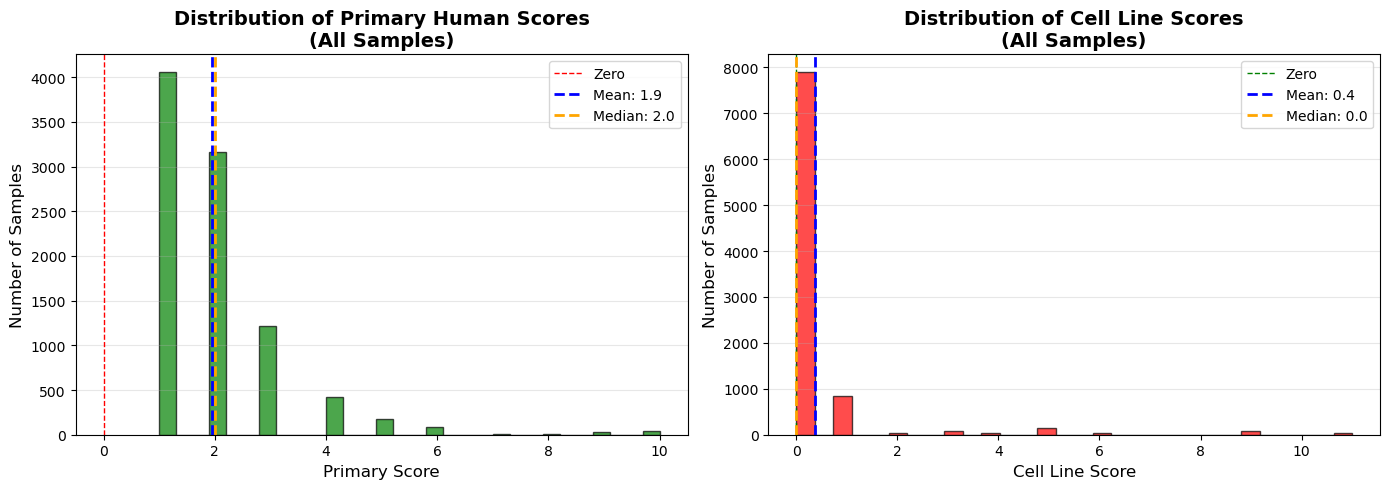


Primary Score Statistics:
  Mean: 1.95
  Median: 2.00
  Min: 1
  Max: 10
  Samples with score > 0: 9,201 (100.0%)

Cell Line Score Statistics:
  Mean: 0.37
  Median: 0.00
  Min: 0
  Max: 11
  Samples with score > 0: 1,313 (14.3%)


In [33]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Extract scores as lists
primary_scores = score_df['primary_score'].to_list()
cell_line_scores = score_df['cell_line_score'].to_list()

# Histogram 1: Primary scores
ax1.hist(primary_scores, bins=30, color='green', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Primary Score', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Distribution of Primary Human Scores\n(All Samples)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')

# Add statistics
primary_mean = sum(primary_scores) / len(primary_scores)
primary_median = sorted(primary_scores)[len(primary_scores)//2]
ax1.axvline(primary_mean, color='blue', linestyle='--', linewidth=2, label=f'Mean: {primary_mean:.1f}')
ax1.axvline(primary_median, color='orange', linestyle='--', linewidth=2, label=f'Median: {primary_median:.1f}')
ax1.legend()

# Histogram 2: Cell line scores
ax2.hist(cell_line_scores, bins=30, color='red', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Cell Line Score', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Distribution of Cell Line Scores\n(All Samples)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axvline(0, color='green', linestyle='--', linewidth=1, label='Zero')

# Add statistics
cell_line_mean = sum(cell_line_scores) / len(cell_line_scores)
cell_line_median = sorted(cell_line_scores)[len(cell_line_scores)//2]
ax2.axvline(cell_line_mean, color='blue', linestyle='--', linewidth=2, label=f'Mean: {cell_line_mean:.1f}')
ax2.axvline(cell_line_median, color='orange', linestyle='--', linewidth=2, label=f'Median: {cell_line_median:.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nPrimary Score Statistics:")
print(f"  Mean: {primary_mean:.2f}")
print(f"  Median: {primary_median:.2f}")
print(f"  Min: {min(primary_scores):.0f}")
print(f"  Max: {max(primary_scores):.0f}")
print(f"  Samples with score > 0: {sum(1 for s in primary_scores if s > 0):,} ({sum(1 for s in primary_scores if s > 0)/len(primary_scores)*100:.1f}%)")

print(f"\nCell Line Score Statistics:")
print(f"  Mean: {cell_line_mean:.2f}")
print(f"  Median: {cell_line_median:.2f}")
print(f"  Min: {min(cell_line_scores):.0f}")
print(f"  Max: {max(cell_line_scores):.0f}")
print(f"  Samples with score > 0: {sum(1 for s in cell_line_scores if s > 0):,} ({sum(1 for s in cell_line_scores if s > 0)/len(cell_line_scores)*100:.1f}%)")